## Rebinding time distribution numerical simulation

In [1]:
import sys
import math
import numpy as np
from numpy import pi, sqrt, inf, log
from ecell4 import *

L = 100
voxel_radius = 0.005
D = 1
rng = GSLRandomNumberGenerator()
rng.seed(1)
kD = 4 * pi * (2 * voxel_radius) * D
dt = (4 * voxel_radius * voxel_radius) / (6 * D)
p=1 #alpha
w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxel_radius, Integer3(3, 3, 3), rng)

def singlerunA(dt, Pacc,alpha): #Diffusion-influenced scheme
    assert Pacc*alpha  <= 1
    assert alpha<=1
    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)
    dt = dt*alpha
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and t < maxtime:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc * alpha >= w.rng().uniform(0, 1):
                return t
        elif alpha >= w.rng().uniform(0, 1):
            coord2 = newcoord
            nsteps += 1
        t += dt      
    return False

def singlerunB(dt, Pacc): #activation-limited scheme
    assert Pacc<= 1
    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)
    dt = dt
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and t < maxtime:
        rnd = w.rng().uniform_int(0, 11)    
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc >= w.rng().uniform(0, 1):
                return t
        else:
            coord2 = newcoord
        t += dt
        nsteps += 1
    return False

### Set ka/kD ratio and number of runs

In [2]:
ka_factor = 1 #ka/kD ratio 0.1,1,100
ntrials = 10# number of runs, 10000 runs used in the paper

ka = kD * ka_factor
r0=0.256318
Pacc = (1/r0-1)*ka_factor
maxtime= 1
if Pacc>1:
    res = [singlerunA(dt, Pacc,p/Pacc) for _ in range(ntrials)]
else:    
    res = [singlerunB(dt, Pacc) for _ in range(ntrials)]

rebtimes=[t for t in res if t!=False] #list of rebinding time

### load and plot rebinding time data used in the paper

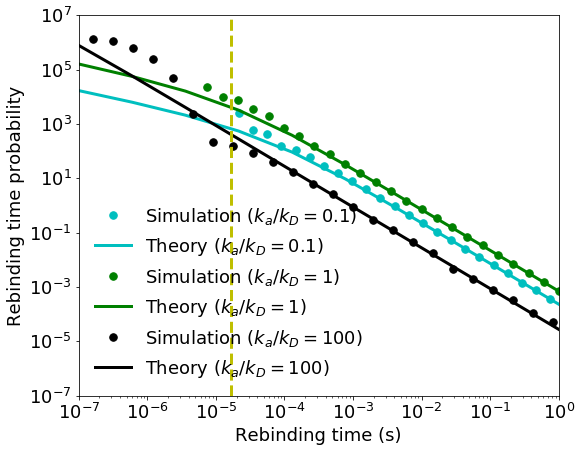

In [3]:
import sys
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler
from scipy import special
voxel_radius=0.005
D=1
tm = (4 * voxel_radius * voxel_radius) / (6 * D)
sz=15
fs=18
lw=3
names = ["kfac0.1trial700000","kfac1.0trial400000","kfac100.0trial800000"]
kfacs=[0.1,1,100]
kD = 4 * np.pi * (2 * voxel_radius) * D
R0=0.256318
R = 2*voxel_radius
fig,ax1=plt.subplots(1,1,figsize=(8.6,7))
ax1.set_prop_cycle(cycler('color', ['c', 'c','g', 'g','k','k']) )

def phix(x):
    return special.erfcx(x)

def f(t):
    x = t**0.5
    return (1./math.pi**0.5 /x - phix(x))

def gethist(times,nt): #calculate the historgram
    hist, bin_edges = np.histogram(times,bins=np.logspace(np.log10(min(times)),np.log10(max(times)),30))
    tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
    binwid = -(bin_edges[:-1]-bin_edges[1:])
    ft = hist/nt/binwid
    return tt,ft

def theorykaf(kfac,tt): #theoretical rebinding probability curve
    ka = kD * kfac
    tmol = R*R/D/(1+ka/kD)**2
    tau = tt/tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(tt,f(tau)*Nfactor,'-',label='Theory ($k_a/k_D='+str(kfac)+'$)',linewidth=lw)
    return 

for i,name in enumerate(names):
    kfac=kfacs[i]
    ka = kD * kfac
    Pacc = ka / (6 * 2**0.5 * D * voxel_radius)
    #load list of rebinding times
    times = np.loadtxt('data/'+name,delimiter=',')
    nt = int(name[-6:])#number of runs
    dt= np.unique(np.sort(times))[1]
    times+=dt
    tt,ft=gethist(times,nt)
    ax1.plot(tt,ft,'.',label='Simulation ($k_a/k_D='+str(kfac)+'$)',markersize=sz)
    theorykaf(kfac,np.logspace(-7,0,10))

ax1.plot([tm]*10,np.logspace(-7,7,10),'y--',linewidth=lw)
ax1.legend(loc=3,fontsize=fs,frameon=False)
ax1.set_xlabel('Rebinding time (s)',fontsize=fs)
ax1.set_ylabel('Rebinding time probability',fontsize=fs)
ax1.set_xlim([1e-7,1])
ax1.set_ylim(1e-7,1e7)    
ax1.tick_params(labelsize=fs)      